# Overview

- pymmc3 で breast_cancer データセットを解析してみる

# Const

In [30]:
cp = ['#f8b195', '#f67280', '#c06c84', '#6c5b7b', '#355c7d']

# Import everything I need :)

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer
import daft
import pymc3 as pm
from scipy import stats

# My Function

# Preparation

set

In [14]:
sns.set()
pd.set_option('display.max_columns', 100)

<br>

load dataset

In [18]:
cancer = load_breast_cancer()
target = cancer.target
data = cancer.data
feat_names = cancer.feature_names
df = pd.DataFrame(data, columns=feat_names)
df['target'] = target

# Analysis

plot histgram

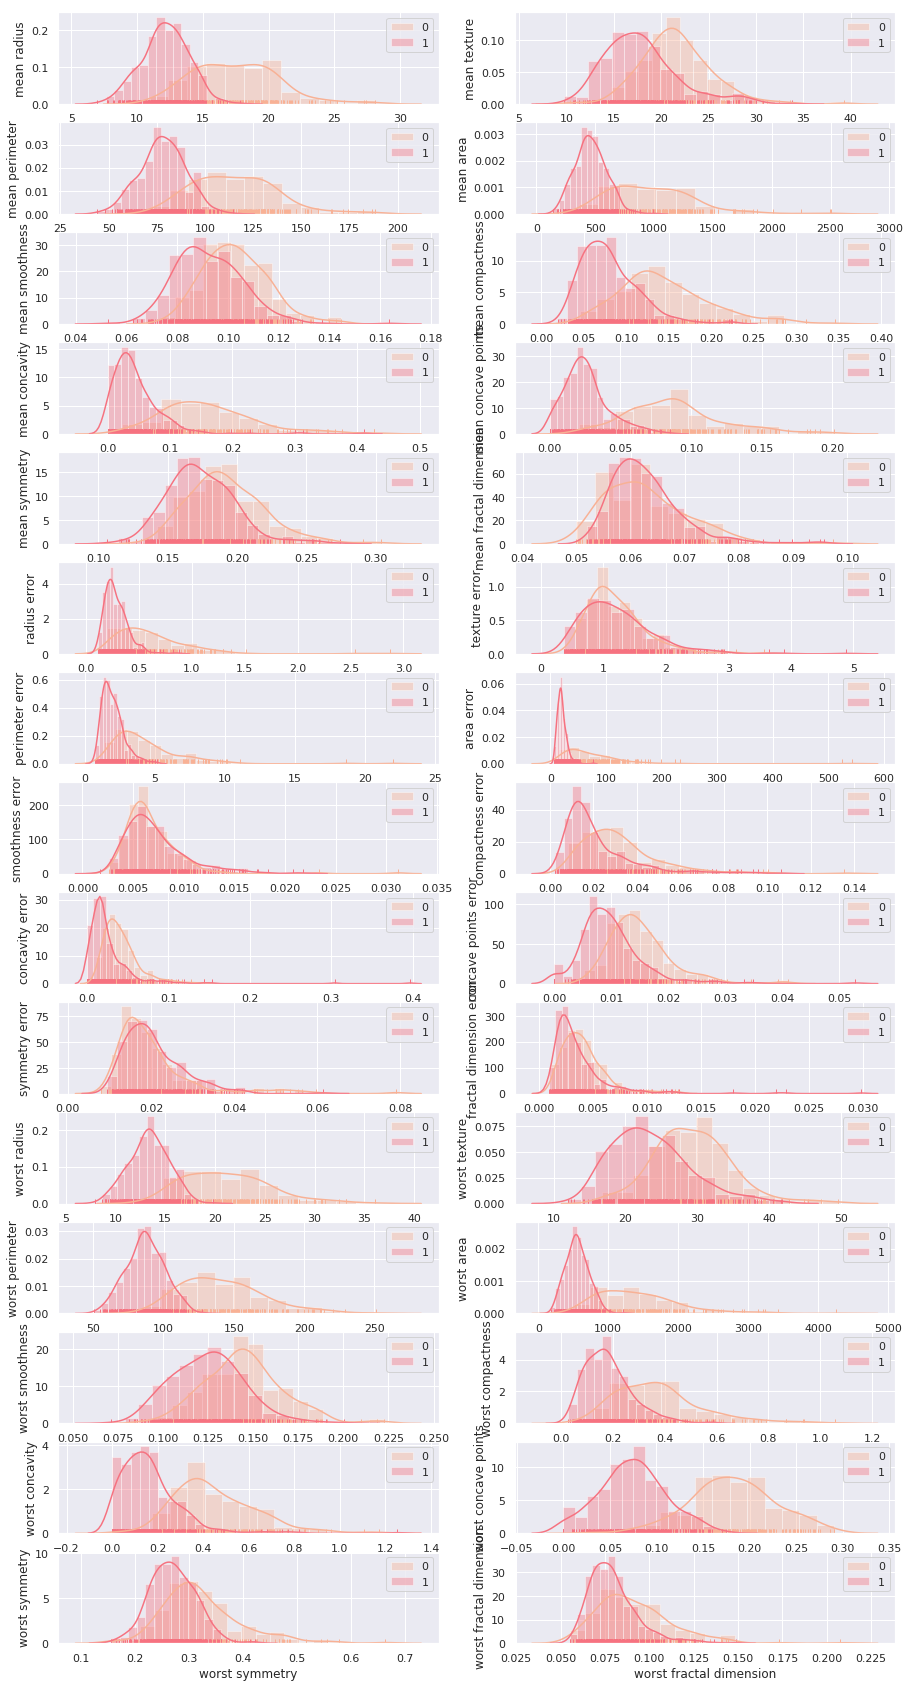

In [59]:
fig, axs = plt.subplots(int(len(feat_names)/2), 2, figsize=(15, 30))
axs = axs.ravel()

for i_feat, feat in enumerate(feat_names):
    _y0 = df[feat][target==0]
    _y1 = df[feat][target==1]
    sns.distplot(_y0, color=cp[0], ax=axs[i_feat], rug=True, label='0')
    sns.distplot(_y1, color=cp[1], ax=axs[i_feat], rug=True, label='1')
    axs[i_feat].set_ylabel(feat)
    axs[i_feat].legend()

> なんとなく、おもしろそうなので、**<font color='orange'>worst perimeter</font>** で遊んでみる  
他のやつではたとえば、`radius error` なんかはガンマ分布なんかで遊ぶと楽しそう

In [77]:
feat_name = 'worst perimeter'
df_wp = df[feat_name]

## worst perimeter
- モデリングを行う
    - ガウス分布を使う
    - mu の事前分布は ガウス分布
    - sigma(tau) の事前分布は一様分布

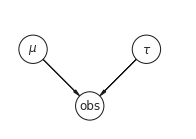

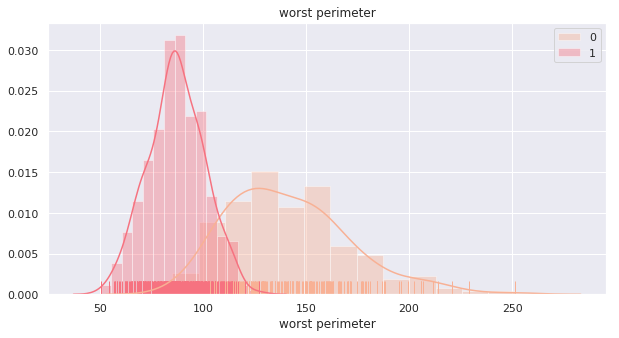

In [80]:
# pgm = daft.PGM(shape=[6,6])
pgm = daft.PGM(shape=[3, 2])

pgm.add_node(daft.Node("mu", r"$\mu$", 1, 3))
pgm.add_node(daft.Node("tau", r"$\tau$", 3, 3))
pgm.add_node(daft.Node("obs", "obs", 2, 2))

# Edges
pgm.add_edge("mu", "obs")
pgm.add_edge("tau", "obs")

pgm.render()
pgm.figure.set_facecolor('white')

plt.figure(figsize=(10, 5))
sns.distplot(df_wp[target==0], color=cp[0], rug=True, label='0')
sns.distplot(df_wp[target==1], color=cp[1], rug=True, label='1')
plt.title(feat_name)
plt.legend()

<br>

modeling

In [95]:
with pm.Model() as models:
    sd0 = pm.Uniform('sd0', 0, 200)
    sd1 = pm.Uniform('sd1', 0, 200)
    mean0 = pm.Normal('mean0', mu=70, sd=50)
    mean1 = pm.Normal('mean1', mu=130, sd=50)
    
    y0 = pm.Normal('y0', mu=mean0, sd=sd0, observed=df_wp.values[target==0]) # 尤度
    y1 = pm.Normal('y1', mu=mean1, sd=sd1, observed=df_wp.values[target==1]) # 尤度
models

<br>

あとで使うmap値を取得しておく
- map推定は事後分布のサンプリング前に行える

In [154]:
with models:
    map_infs = pm.find_MAP()
map_infs

logp = -2,475.1, ||grad|| = 1.426: 100%|██████████| 48/48 [00:00<00:00, 2021.13it/s]  


{'sd0_interval__': array(-1.75883862),
 'sd1_interval__': array(-2.62504318),
 'mean0': array(141.25298093),
 'mean1': array(87.01476766),
 'sd0': array(29.38717087),
 'sd1': array(13.50879427)}

<br>

sampling

In [96]:
%%time
with models:
    step = pm.NUTS() # NUTSでサンプリング
    trace_cg = pm.sample(5000, step=step, chains=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean1, mean0, sd1, sd0]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:07<00:00, 3057.84draws/s]


CPU times: user 7.34 s, sys: 436 ms, total: 7.78 s
Wall time: 11.4 s


<br>

事後分布のプロット

/home/user/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/user/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/user/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/user/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argu

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c4af694a8>,
      dtype=object)

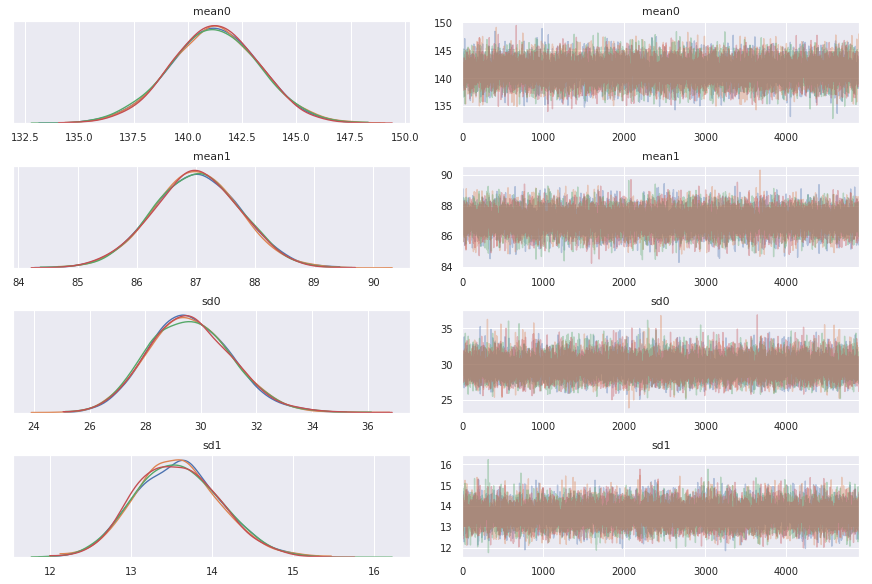

In [97]:
chain_cg = trace_cg[100::]
pm.traceplot(chain_cg)

<br>

`MAP`推定と事後分布の平均値(`EAP`)を比較してみる

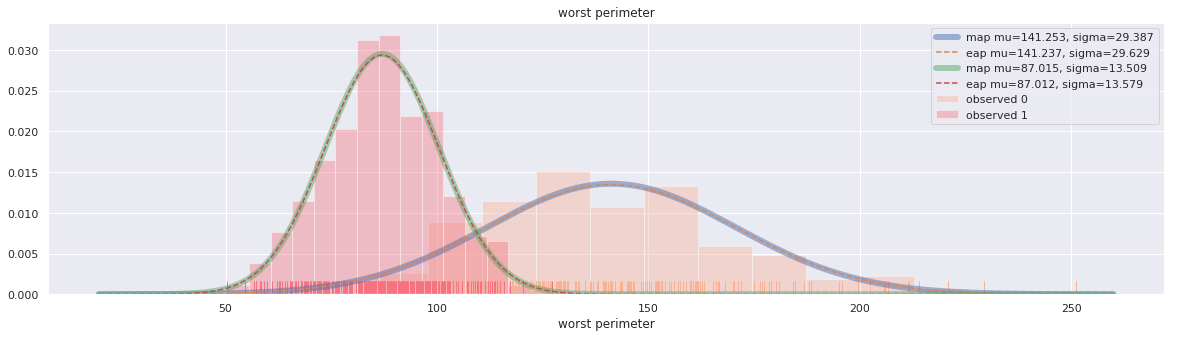

In [146]:
x = np.linspace(20, 260, 200)

plt.figure(figsize=(20, 5))
sns.distplot(df_wp[target==0], color=cp[0], rug=True, label='observed 0', kde=False, norm_hist=True)
sns.distplot(df_wp[target==1], color=cp[1], rug=True, label='observed 1', kde=False, norm_hist=True)
for i in range(2):
    mean_map = map_infs[f'mean{i}']
    mean_eap = chain_cg[f'mean{i}'].mean()
    
    sd_map = map_infs[f'sd{i}']
    sd_eap = chain_cg[f'sd{i}'].mean()

    norm_map = stats.norm.pdf(x, mean_map, sd_map)
    norm_eap = stats.norm.pdf(x, mean_eap, sd_eap)
    
    plt.plot(x, norm_map, label=f'map mu={mean_map:.3f}, sigma={sd_map:.3f}', lw=6, alpha=0.5)
    plt.plot(x, norm_eap, label=f'eap mu={mean_eap:.3f}, sigma={sd_eap:.3f}', linestyle='--')
plt.title(feat_name)
plt.legend()

> map と eap はほとんど一致

<br>

0 と 1 で平均値に差はあるか？

Text(0.5, 1.0, 'diff = mean0 - mean1')

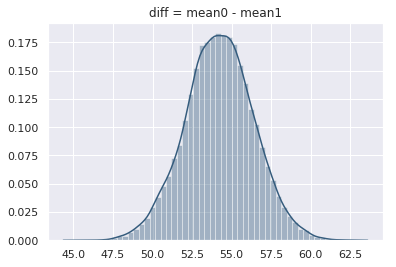

In [153]:
diff_mean = chain_cg['mean0'] - chain_cg['mean1']
sns.distplot(diff_mean, color=cp[4])
plt.title('diff = mean0 - mean1')

> 違いはあきらか。0と1で平均値に差があると言っていいだろう。

# おまけ



## いろいろなサンプリング方法
- start はmap推定値を与える

In [194]:
with models:
    for step in [pm.NUTS, pm.Metropolis, pm.HamiltonianMC, pm.Slice]:
        print('\n'*2)
        print(f'----- {step} -----')
        trace_cg = pm.sample(1000, step=step(), start=map_infs, chains=4)




----- <class 'pymc3.step_methods.hmc.nuts.NUTS'> -----


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean1, mean0, sd1, sd0]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2566.29draws/s]





----- <class 'pymc3.step_methods.metropolis.Metropolis'> -----


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mean1]
>Metropolis: [mean0]
>Metropolis: [sd1]
>Metropolis: [sd0]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 3714.37draws/s]
The number of effective samples is smaller than 10% for some parameters.





----- <class 'pymc3.step_methods.hmc.hmc.HamiltonianMC'> -----


Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [mean1, mean0, sd1, sd0]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2055.91draws/s]





----- <class 'pymc3.step_methods.slicer.Slice'> -----


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [mean1]
>Slice: [mean0]
>Slice: [sd1]
>Slice: [sd0]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1386.42draws/s]


> slice が一番はやい